<a href="https://colab.research.google.com/github/oleg1601/Mortem/blob/master/Shape_Detector_using_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [0]:
!wget 'https://github.com/oleg1601/Mortem/blob/master/mini_classes_full.txt'

--2020-01-11 16:08:34--  https://github.com/oleg1601/Mortem/blob/master/mini_classes.txt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘mini_classes.txt’

mini_classes.txt        [ <=>                ]  71.69K  --.-KB/s    in 0.03s   

2020-01-11 16:08:34 (2.73 MB/s) - ‘mini_classes.txt’ saved [73412]



Read the classes names 

In [0]:
f = open("mini_classes_full.txt","r")
# And for reading use
classes = f.readlines()
f.close()
count = len(classes)
print(count)

78


In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download() 

# Imports 

In [0]:
import os
import glob
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

TensorFlow 2.x selected.


# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [0]:
def load_data(root, vfold_ratio=0.05, max_items_per_class= 5000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))
    # root -- announces the name of the folder, where our classes save
    # vfold_ratio -- define in percent how many items from one class distribute for test, in our way it is 20% 
    # max_items_per_class -- number of elements which we take from one class
    # glob.glob -- return a possibly-empty list of path names that match pathname, which must be a string containing a path specification.
    # in our code we return pathway as os.path.join(folder's name; and add to it .npy to define it as numpy model)

    #initialize variables 
    x = np.empty([0, 784]) # np.empty for X -- define empty array to store multi-dimensional data where 
                           # 784 count of pixel number in our pictures to order in memory.
    y = np.empty([0])      # np.empty for Y -- define empty array to store sequence number of pictures from class
    class_names = []       # define empty array to store class names from data

    #load each data file 
    for idx, file in enumerate(all_files):     # define each file from data
        data = np.load(file)                   # initialise load files
        data = data[0: max_items_per_class, :] # load files from 0 to max_items_per_class, colon -- means all file in list
        labels = np.full(data.shape[0], idx)   # np.full -- return a new array of given shape. 
                                               # The shape attribute for numpy arrays returns the dimensions of the array. 
                                               # If data has n rows and m columns, then data.shape is (n,m). So data.shape[0] is n.

        x = np.concatenate((x, data), axis=0)  # Join a sequence of arrays along an existing axis
        y = np.append(y, labels)               # np.append -- function is used to merge two arrays. 
                                               # This function returns a new array and the original array remains unchanged.

        class_name, ext = os.path.splitext(os.path.basename(file)) 
        # Split the pathname path into a pair (root, ext) such that root + ext == path,
        # and ext is empty or begins with a period and contains at most one period.
        class_names.append(class_name) 

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0]) 
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100)) 

    x_test = x[0:vfold_size, :] # allocate files from 0 to vfold_size for testing, colon -- means all file in list
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :] # allocate others files for training 
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data') # load requable files
num_classes = len(class_names) # count element for neural network
image_size = 28 # define size of image

In [0]:
print(len(x_train))

370500


Show some random data 

brain


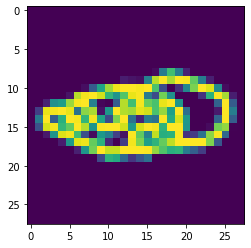

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')
# pre-proces the data by ensuring the image are of shape 28*28*1 and converting the pixels into a float type variable for training

x_train /= 255.0 # x_train =np.interp(x_train, [0, 255], [0, 1]) -- alternatile form
                 # in other word it is simpe interpolation for pixel scaling
x_test /= 255.0

# Convert class vectors to class matrices
# we convert the class labels to one hot for trainig
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [0]:
# Define model with 9 layers
model = keras.Sequential() # Define type of model anfd start add layers
model.add(layers.Convolution2D(64, (3, 3), padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(256, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(345, activation='softmax')) 
# Initialize model
Nadam = tf.keras.optimizers.Nadam()
#adam = tf.keras.train.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2304)            

# Training 

In [0]:
model.fit(x = x_train, y = y_train, validation_split=0.01, batch_size=258, verbose=2, epochs=5)

Train on 366795 samples, validate on 3705 samples
Epoch 1/5
366795/366795 - 19s - loss: 1.3411 - top_k_categorical_accuracy: 0.8669 - val_loss: 0.9186 - val_top_k_categorical_accuracy: 0.9309
Epoch 2/5
366795/366795 - 18s - loss: 0.8194 - top_k_categorical_accuracy: 0.9368 - val_loss: 0.7793 - val_top_k_categorical_accuracy: 0.9404
Epoch 3/5
366795/366795 - 18s - loss: 0.6920 - top_k_categorical_accuracy: 0.9488 - val_loss: 0.7242 - val_top_k_categorical_accuracy: 0.9417
Epoch 4/5
366795/366795 - 18s - loss: 0.6104 - top_k_categorical_accuracy: 0.9562 - val_loss: 0.7184 - val_top_k_categorical_accuracy: 0.9447
Epoch 5/5
366795/366795 - 18s - loss: 0.5431 - top_k_categorical_accuracy: 0.9622 - val_loss: 0.7249 - val_top_k_categorical_accuracy: 0.9417


# Testing 

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 94.11%


# Inference 

['carrot', 'paintbrush', 'asparagus', 'toothbrush', 'crayon']
[197 154  97  96  20]


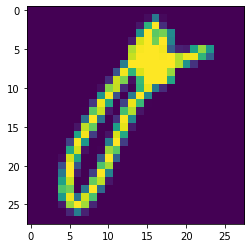

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx] ######## Check it with screenshots
#plt.subplot(2,2,1)  # Building Space for Image
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
indicator = (-pred).argsort()[:5]
latex = [class_names[x] for x in indicator] # Possible Variants
indicator.sort() # Sort value of indicator
new_ind = indicator[::-1] # Making reverse values of indicator
print(latex)
print(new_ind)

In [0]:
#plt.subplot(2,1,2)  # Building Space for Diagram
plot = plt.bar(latex, new_ind, color = "darkblue", alpha=0.8, width=0.7) 
# Initialize diagram with possible variants of our image
plot[0].set_color('r') # Draw Max point in Red colour
for value in plot: # Initialize for writing indicatour value in the top of bar 
    height = value.get_height()- 257
    plt.text(value.get_x() + value.get_width()/2.0,
             2.002*height,'%d' % int(height + 257), ha='center', va='bottom')
plt.title('Possible Prediction')
plt.xlabel('Variants')
plt.ylabel('Percent value')

# Store the classes 

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [0]:
!pip install tensorflowjs 

# Save and Convert 

In [0]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download 

In [0]:
!cp class_names.txt model/class_names.txt

In [0]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/model.json (deflated 82%)
  adding: model/class_names.txt (deflated 43%)


In [0]:
from google.colab import files
files.download('model.zip')